In [31]:
import numpy as np
import scipy
import librosa as lr
from matplotlib import pyplot as plt
import IPython.display as ipd
import soundfile as sf

import sys
sys.path.append("../")
import utils


In [32]:
## Load Audio Signal
def AudioShow(y, sr, title=None):
    time = np.linspace(0, len(y)/sr, len(y))
    plt.figure(figsize=(15, 3))
    plt.plot(time, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    if title:
        plt.title(title)
    plt.xlim(0, time[-1])
    plt.grid()
    plt.show()

def AudioRead(path, plotopt=True):
    y, sr = lr.load(path, sr=None)
    time = np.linspace(0, len(y)/sr, len(y))
    print("{} samples loaded in {} Hz".format(len(y),sr))
    print(f"Total duration: {time[-1]:.5f} seconds")
    
    if plotopt:
        AudioShow(y, sr)
    return y, sr

def AudioWrite(y, sr, path):
    sf.write(path, y, sr)
    
def AudioSpec(signal, sr, n_fft=1024, title=None, xlim=None, PlotPhase=False):
    freqs = np.linspace(0, sr/2, n_fft//2) / 1000 
    signal_f = np.fft.rfft(signal, n_fft)[:-1]
    figsize = (18,2)

    # Plot FFT Magnitude Spectrum in DB Scale
    plt.figure(figsize=figsize)
    plt.plot(freqs, 20 * np.log10(np.abs(signal_f)), label='Original')
    plt.grid(True)
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Amplitude (dB)')
    if title:
        title_m = "Magnitude " + title
        plt.title(title_m)
        
    if xlim:
        xlim = xlim
    else:
        xlim = [0,sr//2/1000]
    
    plt.xlim(xlim)
    step = xlim[-1] / 8
    tick_marks = np.arange(xlim[0],xlim[-1]+0.1,  step)
    plt.xticks(tick_marks,[f"{(x)} kHz" for x in tick_marks])
    plt.show()
    
    if PlotPhase:
        plt.figure(figsize=figsize)
        plt.plot(freqs, (np.angle(signal_f)), label='Original')
        plt.grid(True)
        plt.xlabel('Frequency (kHz)')
        plt.ylabel('Phase (rad)')
        plt.title("Phase Spectrum")
        
        if title:
            title_p = "Phase " + title
            plt.title(title_p)
            
        if xlim:
            xlim = xlim
        else:
            xlim = [0,sr//2/1000]
        
        plt.xlim(xlim)
        step = xlim[-1] / 8
        tick_marks = np.arange(xlim[0],xlim[-1]+0.1,  step)
        plt.xticks(tick_marks,[f"{(x)} kHz" for x in tick_marks])
        
        # y_ticks = np.array([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        # y_labels = ['$-\pi$', '$-\\frac{\pi}{2}$', '0', '$\\frac{\pi}{2}$', '$\pi$']
        y_ticks = np.array([-np.pi, 0, np.pi])
        y_labels = ['$-\pi$',  '0', '$\pi$']
        plt.yticks(y_ticks, y_labels)
        plt.show()

283656 samples loaded in 16000 Hz
Total duration: 17.72850 seconds


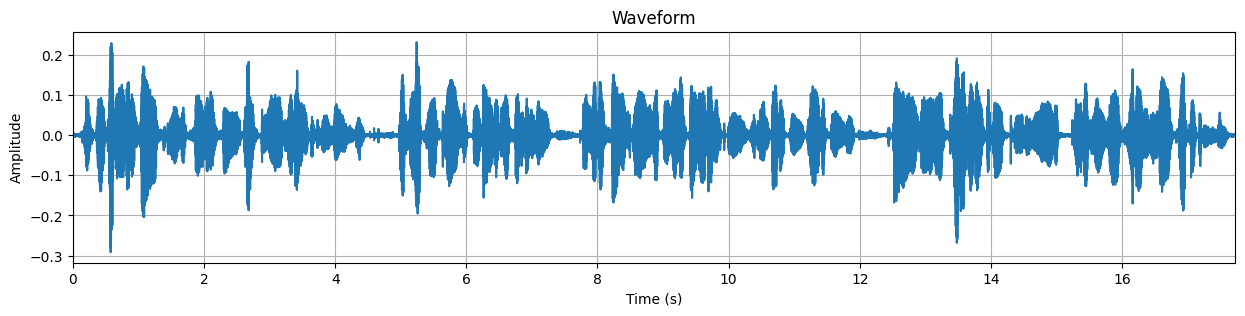

In [33]:
# Load Waves
path = "speech_16kHz.wav"
y, sr = AudioRead(path, plotopt=False)
AudioShow(y,sr)

In [34]:
def Spectrogram(y, sr, win_len, hop_len, win_type="hamming", n_fft=1024, dbscale=True, yscale='linear', plotopt=True, title=None):

    # Extract Frames
    FE = utils.FrameExtractor(y,win_len=win_len,hop_len=hop_len)
    specgram = FE.STFT(win_type="hamming",dft_len=n_fft)
    # print(specgram.shape)
    specgram = np.abs(specgram)
    
    if dbscale:
        specgram=lr.amplitude_to_db(specgram, ref=np.max)
    
    # Plot Spectrogram
    if plotopt:
        fig,ax = plt.subplots(sharex=True,figsize=(20,5))
        img=lr.display.specshow(specgram, sr=sr, ax=ax, hop_length=int(win_len/2), x_axis='time', y_axis=yscale, cmap='jet')
        ax.set_xlabel("Time(s)", fontsize=15)
        ax.set_ylabel("Hz",fontsize=15)
        ax.tick_params(axis="both",labelsize=15)
        ax.set_title("Window Length: {} ms".format(win_len/sr*1000),fontsize=25)
        if title:
            ax.set_title(title,fontsize=25)


        if dbscale: 
            cbar=plt.colorbar(img, format="%+2.f dB", ax=ax)
        else:
            cbar=plt.colorbar(img, format="%+2.f", ax=ax)

        cbar.ax.tick_params(labelsize=14)
        plt.show()
    return specgram

## Spectrogram

283656 samples loaded in 16000 Hz
Total duration: 17.72850 seconds
Frame extracted with hamming window


From 283656 samples, total 8863 frames are generated


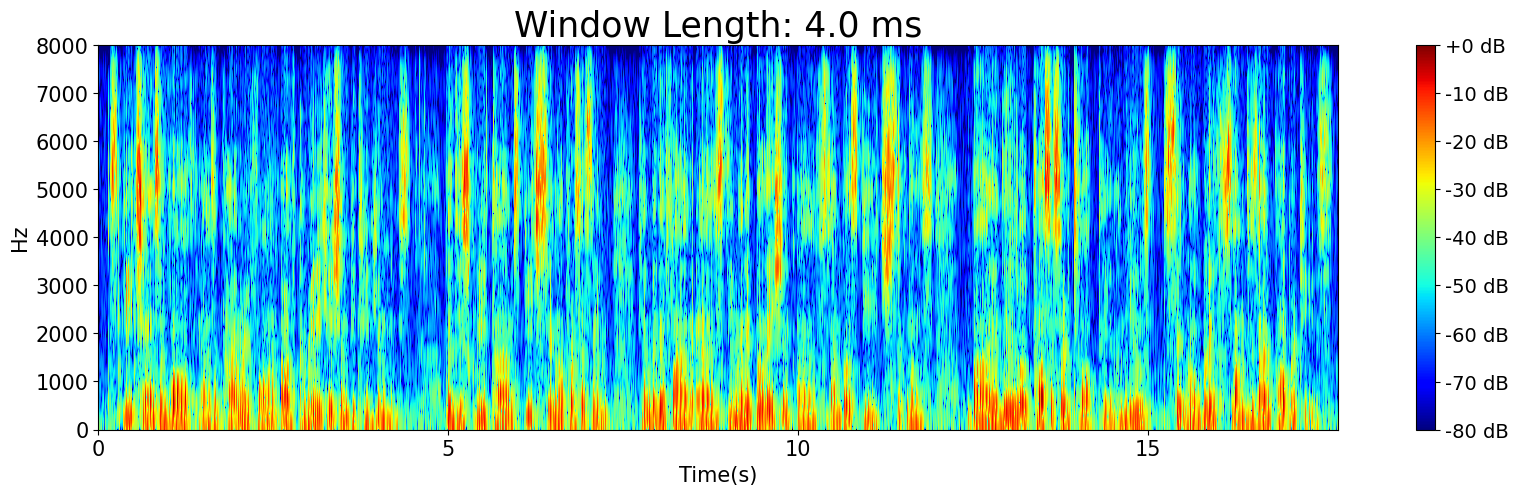

Frame extracted with hamming window
From 283656 samples, total 1107 frames are generated


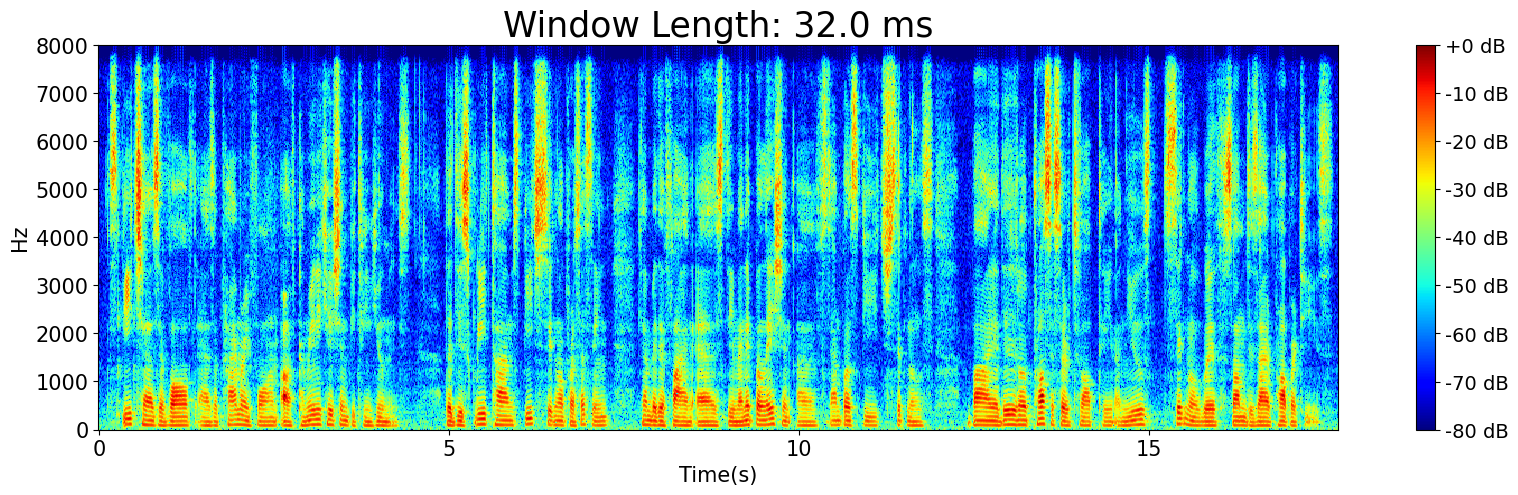

In [35]:
## Spectrogram
""" Plot Narrowband and Wideband Spectrogram """

path = "speech_16kHz.wav"
# path = "../SATEST-main/SATEST-main/yonseicrop.wav"
y, sr = AudioRead(path, plotopt=False)

## WideBand : 4ms window
## NarrowBand : 32ms window
win_time = 0.004
win_len = int(win_time * sr)
hop_len = win_len//2

wide_specgram = Spectrogram(y, sr, win_len, hop_len, dbscale=True, n_fft=2048, yscale='linear', plotopt=True)
narr_specgram = Spectrogram(y, sr, win_len=win_len*8, hop_len=hop_len*8, dbscale=True, n_fft=2048, yscale='linear', plotopt=True)

In [36]:
# # Compare with Librosa
# # 뒷 부분 frame이 추출되지 않으며 날아간 부분만 약간 소실 됨
# # 2개 frame 개수만 차이나는 듯

# fig, ax = plt.subplots(figsize=(20,5))
# S = np.abs(lr.stft(y, hop_length=hop_len, win_length=win_len, window="hamming"))
# img = lr.display.specshow(lr.amplitude_to_db(S,ref=np.max), sr=sr,
#                                 hop_length=hop_len, win_length=win_len,
#                                 y_axis='lienar', x_axis='s', ax=ax, cmap='jet')
# ax.set_title('Power spectrogram')
# fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Mel-Spectrogram

In [37]:
def MelSpectrogram(y, sr, win_len, hop_len, win_type="hamming", n_fft=2048, fbnum=80, plotopt=True, title=None):

    # Extract Frames
    FE = utils.FrameExtractor(y,win_len=win_len,hop_len=hop_len)
    specgram = FE.STFT(win_type=win_type,dft_len=n_fft)
    specgram = np.abs(specgram)
    
    # Mel-Filter Bank
    melfb = lr.filters.mel(sr=sr,n_fft=n_fft,fmax=sr//2,n_mels=fbnum)
    melspec = np.matmul(melfb, np.power(specgram,2))
    melspec = lr.power_to_db(melspec)
    
    # Plot Spectrogram
    if plotopt:
        fig,ax = plt.subplots(sharex=True,figsize=(20,5))
        img=lr.display.specshow(melspec, sr=sr, ax=ax, hop_length=int(win_len/2), x_axis='time', y_axis='mel', cmap='jet')
        ax.set_xlabel("Time(s)", fontsize=15)
        ax.set_ylabel("Hz",fontsize=15)
        ax.tick_params(axis="both",labelsize=15)
        ax.set_title("Window Length: {} ms".format(win_len/sr*1000),fontsize=25)
        if title:
            ax.set_title(title,fontsize=25)

        cbar=plt.colorbar(img, format="%+2.f dB", ax=ax)
        cbar.ax.tick_params(labelsize=14)
        plt.show()
        
    return melspec


In [38]:
""" MFCC Using librosa Functions """
def MFCC(y, sr, win_len, hop_len, win_type="hamming", n_fft=2048, fbnum=80, plotopt=True):
    # Mel Spectrogram
    # Extract Frames and Compute the STFT
    # Instead of manually extracting frames and applying STFT,
    
    melspec = lr.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_len, 
                                        win_length=win_len, window=win_type, n_mels=fbnum, fmax=sr//2)

    # # Convert Power Spectrogram to dB
    log_melspec = lr.power_to_db(melspec, ref=np.max)
    
    # MFCC
    # Extract MFCCs from the log Mel spectrogram
    mfcc = lr.feature.mfcc(S=log_melspec, n_mfcc=fbnum)
    
    # Plotting Option
    if plotopt:
        plt.figure(figsize=(20, 5))
        lr.display.specshow(mfcc, sr=sr, hop_length=hop_len, x_axis='time', cmap='jet')
        plt.colorbar(format='%+2.0f')
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()
    
    return mfcc
    
""" MFCC Using Custom Functions """
def myMFCC(y, sr, win_len, hop_len, win_type="hamming", n_fft=2048, fbnum=80, plotopt=True):
    # Mel Spectrogram
    # Extract Frames and Compute the STFT

    log_melspec = MelSpectrogram(y=y, sr=sr, win_len=win_len, hop_len=hop_len, 
                             win_type=win_type, n_fft=n_fft, fbnum=fbnum, plotopt=False)
    
    # MFCC
    # Extract MFCCs from the log Mel spectrogram
    # mfcc = lr.feature.mfcc(S=log_melspec, n_mfcc=fbnum)
    mfcc = scipy.fftpack.dct(log_melspec, axis=0, 
                                    type=2, norm='ortho')[:fbnum,:]
    print(mfcc.shape)
    # Plotting Option
    if plotopt:
        plt.figure(figsize=(20, 5))
        lr.display.specshow(mfcc, sr=sr, hop_length=hop_len, x_axis='time', cmap='jet')
        plt.colorbar(format='%+2.0f')
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()
    
    return mfcc

"""
Mel Spectrogram 함수와
librosa의 STFT 함수가 그림은 동일하지만, 값이 다른 이유는 왜일까?

확인 결과, 일단 Frame의 절대적인 개수부터 다르다
내가 만든 FE와 동일한 shape을 위해서는, lr 함수의 맨앞과 맨뒤를 제거해야 한다

그럼에도 불구하고 DC 값은 (MFCC-0) 왜 다를까?
"""


'\nMel Spectrogram 함수와\nlibrosa의 STFT 함수가 그림은 동일하지만, 값이 다른 이유는 왜일까?\n\n확인 결과, 일단 Frame의 절대적인 개수부터 다르다\n내가 만든 FE와 동일한 shape을 위해서는, lr 함수의 맨앞과 맨뒤를 제거해야 한다\n\n그럼에도 불구하고 DC 값은 (MFCC-0) 왜 다를까?\n'

283656 samples loaded in 16000 Hz
Total duration: 17.72850 seconds


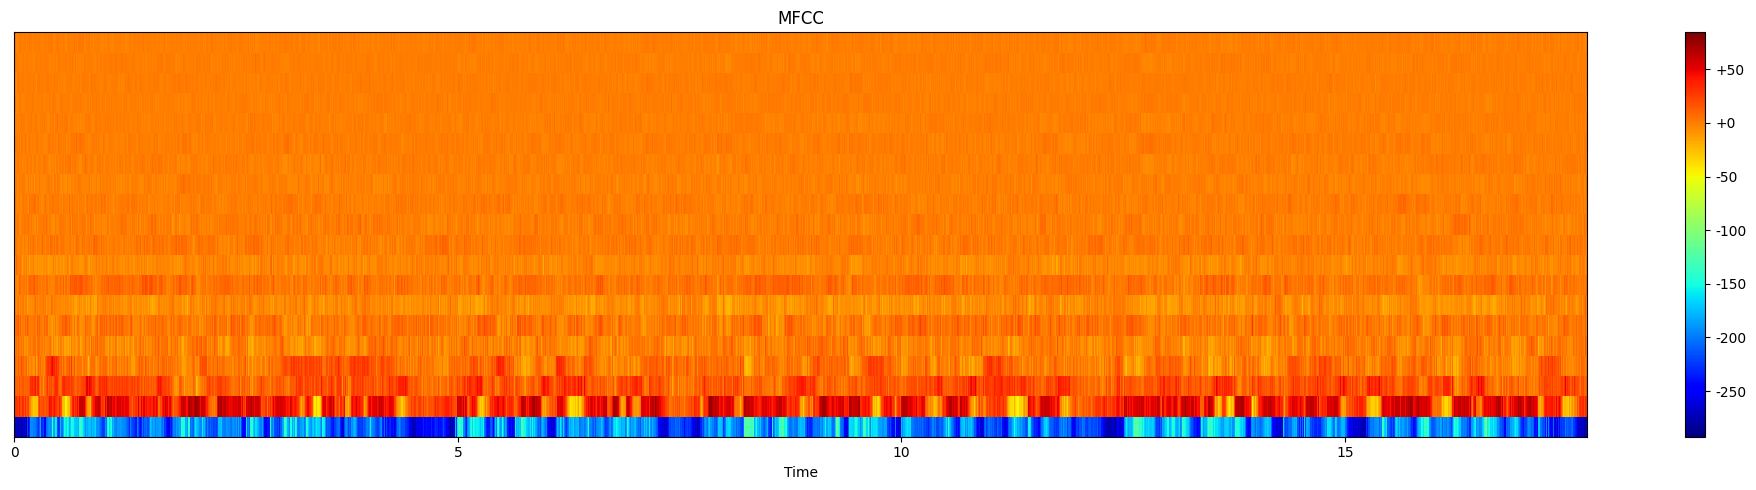

Frame extracted with hamming window
From 283656 samples, total 8863 frames are generated
(20, 8863)


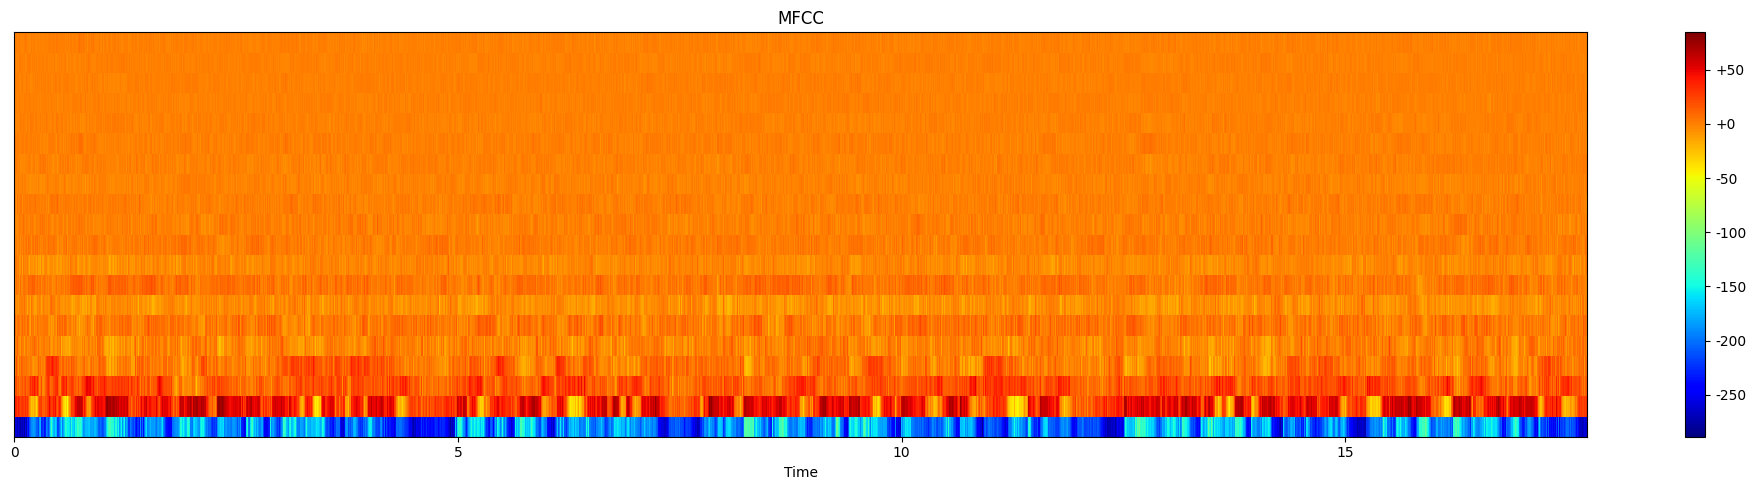

In [39]:
""" Plotting MFCCs """
y, sr = AudioRead(path, plotopt=False)

## WideBand : 4ms window
## NarrowBand : 32ms window
win_time = 0.004
win_len = int(win_time * sr)
hop_len = win_len//2
t = MFCC(y, sr, win_len, hop_len, win_type="hamming", n_fft=2048, fbnum=20, plotopt=True)
t2 = myMFCC(y, sr, win_len, hop_len, win_type="hamming", n_fft=2048, fbnum=20, plotopt=True)


# np.set_printoptions(precision=2, suppress=True)
# ## 내가 만든 FE와 동일하기 위해서는, 맨앞과 맨뒤의 frame을 제거해야 동일하다
# ## 그럼에도 DCT의 DC term (MFCC-0) 값은 다르다
# t = t[:,1:-1]
# print(t[:,10:15])
# print(t2[:,10:15])
# print(t.shape)
# print(t2.shape)
# print(t[:,:3])
# print(t2[:,:3])

Frame extracted with hamming window
From 283656 samples, total 8863 frames are generated


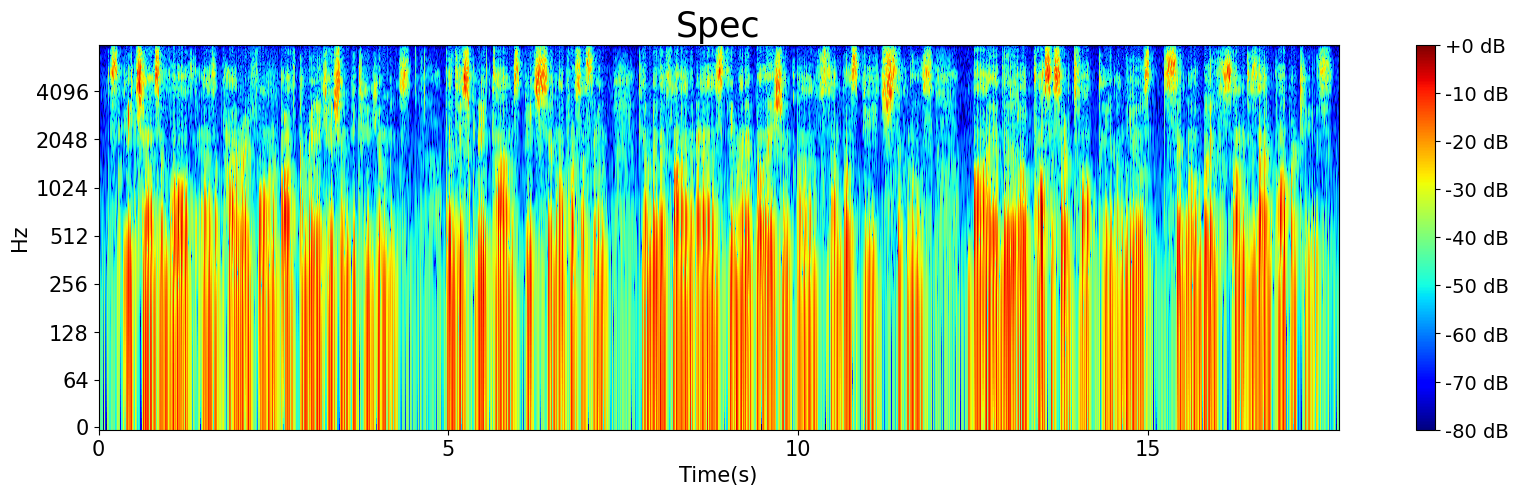

Frame extracted with hamming window
From 283656 samples, total 8863 frames are generated


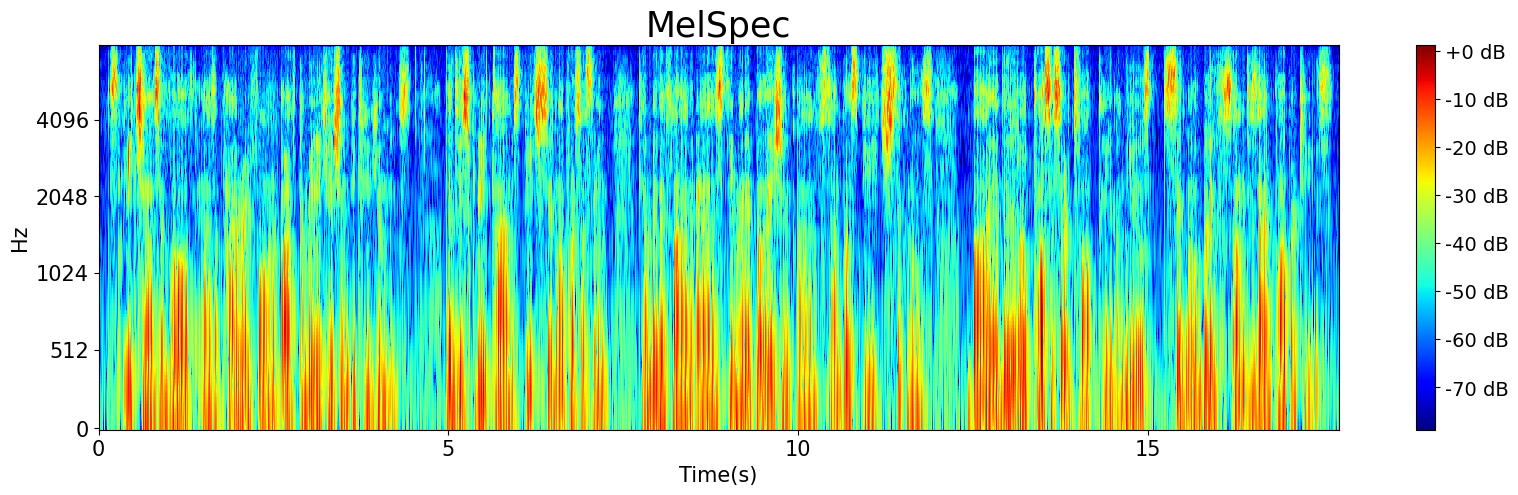

In [40]:
wide_specgram = Spectrogram(y, sr, win_len, hop_len, dbscale=True, n_fft=2048, yscale='log', plotopt=True,title="Spec")
mel = MelSpectrogram(y, sr, win_len, hop_len, win_type="hamming", n_fft=2048, fbnum=128,title="MelSpec")

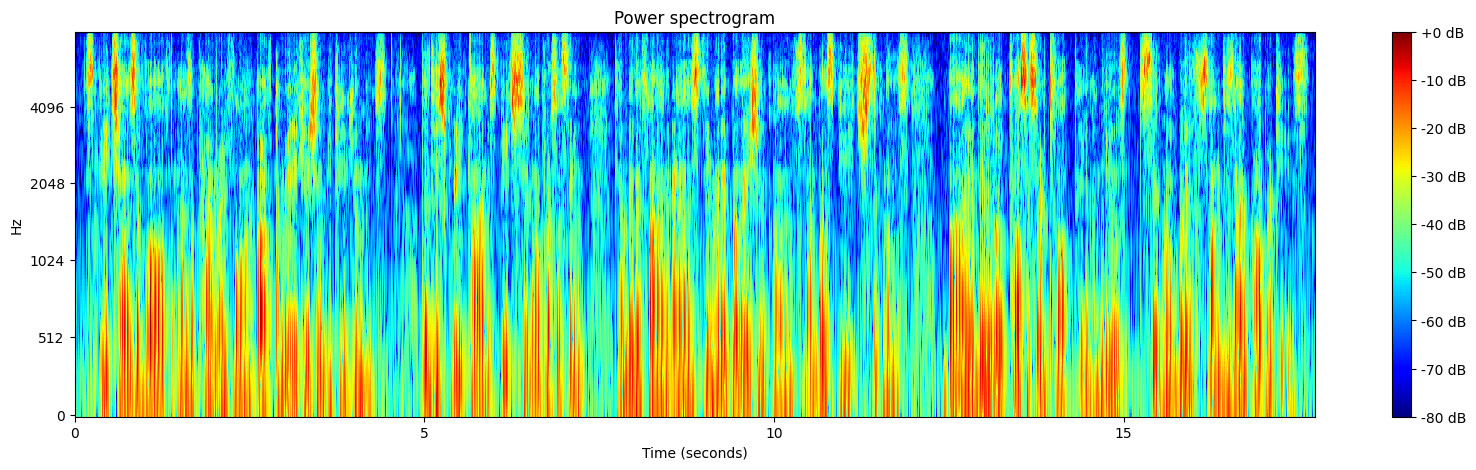

In [41]:
""" Compare with Librosa Mel-Spectrogram """
fig, ax = plt.subplots(figsize=(20,5))
S = lr.feature.melspectrogram(y=y, sr=sr,hop_length=hop_len,win_length=win_len, 
                              window="hamming", n_mels=128, fmax=sr//2)
S_dB = lr.power_to_db(S, ref=np.max)
img = lr.display.specshow(S_dB, sr=sr,
                                hop_length=hop_len, win_length=win_len,
                                y_axis='mel', x_axis='s', ax=ax, cmap='jet')
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

In [42]:
# """ Effect of Windowing and Spectral Leakage """
# f = 500
# sr = 2000
# time = 2
# dftlen = 1024

# t = np.linspace(0,time,int(time*sr))
# print(len(t))

# y = np.sin(2*np.pi*f*t)

# plt.plot(t,y)
# # plt.xlim(0,0.05)
# plt.show()

# freq = np.linspace(0, sr/2, dftlen//2)
# f = np.fft.rfft(y,n=1024)[:-1]
# print(len(f))
# plt.plot(freq,f)
# plt.show()

# ## Frame Extraction

# wintime = 0.02
# winlen = int(0.02 * sr)
# frame = y[:winlen]
# plt.plot(frame)
# plt.show()